# Tugas Besar Analisis Jejaring Sosial <br>
#Deteksi Komunitas<br>
Annisa Miranda - 1301184378<br>
Marcello Rasel Hidayatullah - 1301184019

## Import Libraries dan Data Mentah

In [120]:
import pandas as pd
import json
import networkx as nx
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
import string
string.punctuation
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop = stopwords.words('english')
nltk.download('punkt')
import re
from pandas import DataFrame

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [121]:
raw = pd.read_csv("data_mentah.csv")
raw.head()

,id_str,from_user,text,created_at,time,geo_coordinates,user_lang,in_reply_to_user_id_str,in_reply_to_screen_name,from_user_id_str,in_reply_to_status_id_str,source,profile_image_url,user_followers_count,user_friends_count,user_location,status_url,entities_str
0,1478651446707224579,bushi_gori,RT @bushi_creative: ◤東京リベンジャーズ British Gangste...,Wed Jan 05 08:55:51 +0000 2022,05/01/2022 08:55:51,NaN,NaN,NaN,NaN,1442473982112849925,NaN,"<a href=""https://mobile.twitter.com"" rel=""nofo...",http://pbs.twimg.com/profile_images/1442474168...,16.0,43.0,オーモンド山,http://twitter.com/bushi_gori/statuses/1478651...,"{""hashtags"":[],""symbols"":[],""user_mentions"":[{..."
1,1478651445415378944,vjnxwon,RT @KnySlayer: Anime : Demon Slayer https://t....,Wed Jan 05 08:55:51 +0000 2022,05/01/2022 08:55:51,NaN,NaN,NaN,NaN,1364173825458413568,NaN,"<a href=""http://twitter.com/download/android"" ...",http://pbs.twimg.com/profile_images/1477920270...,73.0,2567.0,NaN,http://twitter.com/vjnxwon/statuses/1478651445...,"{""hashtags"":[],""symbols"":[],""user_mentions"":[{..."
2,1478651442919403520,Hydrangeas_as,RT @HxHShots: Anime: Hunter x Hunter https://t...,Wed Jan 05 08:55:50 +0000 2022,05/01/2022 08:55:50,NaN,NaN,NaN,NaN,862294100917108737,NaN,"<a href=""https://mobile.twitter.com"" rel=""nofo...",http://pbs.twimg.com/profile_images/1301575501...,9.0,178.0,มูฟออนเป็นวงกลม,http://twitter.com/Hydrangeas_as/statuses/1478...,"{""hashtags"":[],""symbols"":[],""user_mentions"":[{..."
3,1478651441568960519,SidiBoateng,RT @SeinenVibes: Anime : Attack On Titan https...,Wed Jan 05 08:55:50 +0000 2022,05/01/2022 08:55:50,NaN,NaN,NaN,NaN,2249217369,NaN,"<a href=""http://twitter.com/download/iphone"" r...",http://pbs.twimg.com/profile_images/1470436538...,1039.0,256.0,91,http://twitter.com/SidiBoateng/statuses/147865...,"{""hashtags"":[],""symbols"":[],""user_mentions"":[{..."
4,1478651439735971842,linsstry,RT @lilaccountz: Bukannya membenarkan tapi men...,Wed Jan 05 08:55:49 +0000 2022,05/01/2022 08:55:49,NaN,NaN,NaN,NaN,1290961601730760705,NaN,"<a href=""http://twitter.com/download/android"" ...",http://pbs.twimg.com/profile_images/1476479132...,58.0,166.0,Inferno,http://twitter.com/linsstry/statuses/147865143...,"{""hashtags"":[],""symbols"":[],""user_mentions"":[{..."


In [122]:
len(raw)

2970

## Pre-Processing

Tahap pertama, mengambil 3 atribut dari data mentah, yaitu username yang memention, username yang dimention, dan strength untuk mendapatkan berapa kali mention dilakukan

1. Case Folding
2. Stop Word Removal
3. Data Cleaning

Case Folding

In [123]:
raw['text'] = raw['text'].str.lower()

Stop Word Removal

In [124]:
raw['text'] = raw['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

Data Cleaning

In [133]:
# Fungsi Remove Punctuation
def remove_punctuation(text):
    return text.translate(str.maketrans("","",string.punctuation))

def remove(text):
  hapus="".join([i for i in text if i not in string.punctuation])
  return hapus
  
raw['text'] = raw['text'].apply(remove_punctuation)
raw['text'] = raw['text'].apply(remove)

In [126]:
# Fungsi menghapus karakter single
def remove_single(text):
    return re.sub(r"\b[a-zA-Z]\b", "", text)

raw['text'] = raw['text'].apply(remove_single)

In [127]:
# Fungsi menghapus karakter spesial
def remove_special(text):
  text = text.replace('\\t'," ").replace('\\n'," ").replace('\\u'," ").replace('\\',"")
  text = text.encode('ascii', 'replace').decode('ascii')
  text = ' '.join(re.sub("([@#][A-Za-z0-9]+)|(\w+:\/\/\S+)"," ", text).split())
  return text.replace("http://", " ").replace("https://", " ")

raw['text'] = raw['text'].apply(remove_special)

In [128]:
# Fungsi menghapus angka
def remove_number(text):
  return  re.sub(r"\d+", "", text)

raw['text'] = raw['text'].apply(remove_number)

In [129]:
# Fungsi menghapus whitespace
def remove_whitespace(text):
    return text.strip()

raw['text'] = raw['text'].apply(remove_whitespace)

In [130]:
# Fungsi menghapus multiple whitespace
def remove_multiple(text):
    return re.sub('\s+',' ',text)

raw['text'] = raw['text'].apply(remove_multiple)

In [131]:
raw['text'] = raw['text'].str.replace('rt', '')
raw['text'] = raw['text'].str.replace('anime', '')
raw['text'] = raw['text'].str.replace('tv', '')
raw['text'] = raw['text'].str.replace('&amp;', '')
raw['text'] = raw['text'].str.replace('amazon', '')
raw['text'] = raw['text'].str.replace('amp', '')

In [134]:
raw['text'].head()

0     bushicreative  british gangsters   bushicreat...
1            knyslayer  demon slayer httpstcotybbacfri
2              hxhshots  hunter hunter httpstcorixnyua
3         seinenvibes  attack titan httpstcoqqezcwjcvt
4     lilaccountz bukannya membenarkan tapi mending...
Name: text, dtype: object

Setelah melakukan pre-processing, dilakukan proses ekstrak edges untuk melakukan deteksi komunitas.

In [135]:
# Mengekstrak edges dari mention
mentions = raw[raw['entities_str'].notnull()]
# Membuat kolom 'Source', 'Target', dan 'Strength'
df_edges = pd.DataFrame(columns=('From User','Mentioned Username','Strength'))

for index, row in mentions.iterrows():
    json_acceptable_string = row['entities_str'].replace("''", "\"")
    js = json.loads(json_acceptable_string)
    mention_list = js['user_mentions']
    for mention in mention_list:
        df_edges = df_edges.append(pd.DataFrame([[row['from_user'], mention['screen_name'], row['created_at']]], columns=('From User','Mentioned Username','Strength')), ignore_index=True)

In [136]:
df_edges.head()

,From User,Mentioned Username,Strength
0,bushi_gori,bushi_creative,Wed Jan 05 08:55:51 +0000 2022
1,bushi_gori,bushi_creative,Wed Jan 05 08:55:51 +0000 2022
2,vjnxwon,KnySlayer,Wed Jan 05 08:55:51 +0000 2022
3,Hydrangeas_as,HxHShots,Wed Jan 05 08:55:50 +0000 2022
4,SidiBoateng,SeinenVibes,Wed Jan 05 08:55:50 +0000 2022


In [137]:
len(df_edges)

3129

In [138]:
# Set min connection
level = 1

edges = df_edges.groupby(['From User','Mentioned Username'])['Strength'].count()
edges = edges.reset_index()
edges = edges[edges['Strength'] >= level]
edges.rename(columns={'Strength': 'Mentions Count'}, inplace=True)
edges.head()

,From User,Mentioned Username,Mentions Count
0,00masan00,fujitvplus,2
1,00xxyz_,lilaccountz,1
2,011794skz,Anime,1
3,01zouu,SageWeeb,1
4,0310_Rmon,LoveLive_staff,1


Setelah didapat jumlah mention, maka export DataFrame tersebut ke file CSV.

In [139]:
edges.to_csv('anime_edges.csv', encoding='utf-8', index=False)

## Deteksi Komunitas Menggunakan Girvan Newman

Proses dari metode Girvan-Newman yaitu :<br>
1. Mencari nilai betweenness tertinggi dari setiap edge.
2. Hapus edge dengan nilai betweenness tertinggi tersebut.
3. Ulangi proses pertama pada edge yang tersisa.
4. Proses selesai ketika edge sudah terhapus semua.

In [140]:
df = pd.read_csv('anime_edges.csv')
df.head()

,From User,Mentioned Username,Mentions Count
0,00masan00,fujitvplus,2
1,00xxyz_,lilaccountz,1
2,011794skz,Anime,1
3,01zouu,SageWeeb,1
4,0310_Rmon,LoveLive_staff,1


In [141]:
# Inisiasi Graph
G = nx.Graph()

for i in range(len(df)):
  G.add_edge(df['From User'][i],df['Mentioned Username'][i])

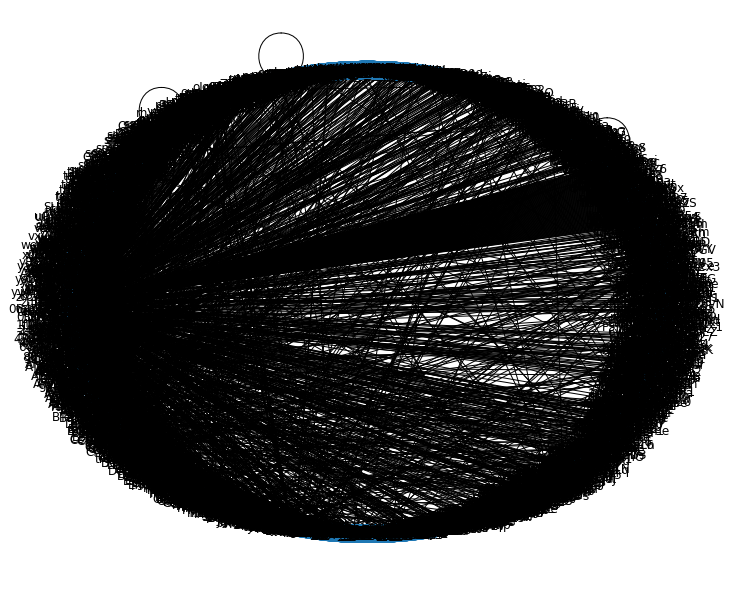

In [142]:
figure(figsize=(10, 8))
nx.draw_shell(G, with_labels=True)

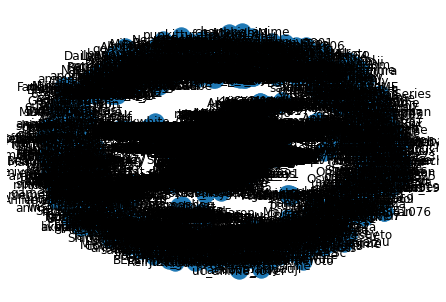

In [143]:
# Visualize the graph
nx.draw(G, with_labels = True)

In [144]:
len(G.nodes), len(G.edges)

(2755, 2530)

Tahap pertama, cari nilai betweenness tertinggi dari edge.

In [145]:
# Fungsi menghapus edge
def edge_to_remove(graph):
  G_dict = nx.edge_betweenness_centrality(graph)
  edge = ()

  # Mengekstrak nilai betweenness edge tertinggi
  for key, value in sorted(G_dict.items(), key=lambda item: item[1], reverse = True):
      edge = key
      break

  return edge

Tahap selanjutnya, hapus edge yang memiliki nilai betweenness tertinggi tersebut.

In [146]:
# Fungsi Algoritma Girvan-Newman
def girvan_newman(graph):
	sg = nx.connected_components(graph)
	sg_count = nx.number_connected_components(graph)

# Hapus edge dengan nilai betweenness tertinggi
	while(sg_count == 1):
		graph.remove_edge(edge_to_remove(graph)[0], edge_to_remove(graph)[1])
		sg = nx.connected_components(graph)
		sg_count = nx.number_connected_components(graph)

	return sg

Tahap selanjutnya mencari komunitas dari graph.

In [147]:
komunitas = girvan_newman(G.copy())
list_komunitas = []

for i in komunitas:
  list_komunitas.append(list(i))

In [148]:
list_komunitas

[['bwiii97',
  'joehokyoku',
  'yuzurionniumu',
  'hitosins',
  'marcfolen',
  'antdarant7',
  'o0_ruk',
  'AT8t55zLCQHkB4u',
  '7gt7',
  'kazsoleya',
  'riririkensyo',
  'ttizzunakin',
  'wajtoto',
  'Coleen_menlove',
  'ShonenFeeling',
  'sarha_san',
  'crunchyroll_es',
  'marouajungkook',
  'Yikiaone',
  '__0916__srtr',
  'nyariwooo',
  'ccttcc4',
  'dappoudaifuku',
  'hwseis_',
  '861jAEPuHU6nNRy',
  'natsuki080230',
  'ZMaub',
  'Maiki_162cm',
  'OderaLawi',
  'Luke_Namalu',
  'Xenon9D',
  'xKamiiSama',
  'Martin3406',
  'P7hWvzHSynxxPKo',
  'aimeraemmii',
  'ir3oluwa',
  'actio15',
  'TkIEgu4nXmCMabi',
  'ark57937070',
  'j67294421',
  'dotoko00',
  'TangInaMoMiyvki',
  'r37niHZt9Q7Vxxh',
  '7uouZzz',
  'akiyukimiura',
  'anbmz10',
  'fuchjppl',
  'znixqv',
  'gmt0900',
  'welisq',
  'Claisen11',
  'ils_124',
  'wt_hpmi_usss',
  'MC_89_2918',
  'RaviMarandi12',
  'oLmQ4Vgk45DHBP6',
  'mini___420',
  'whorified_nsfw',
  'hbxiu',
  'suraimu03sei',
  'mrflyguyjrr',
  'XXNEX0510',
  

In [149]:
len(list_komunitas)

393

### Visualisasi Graph

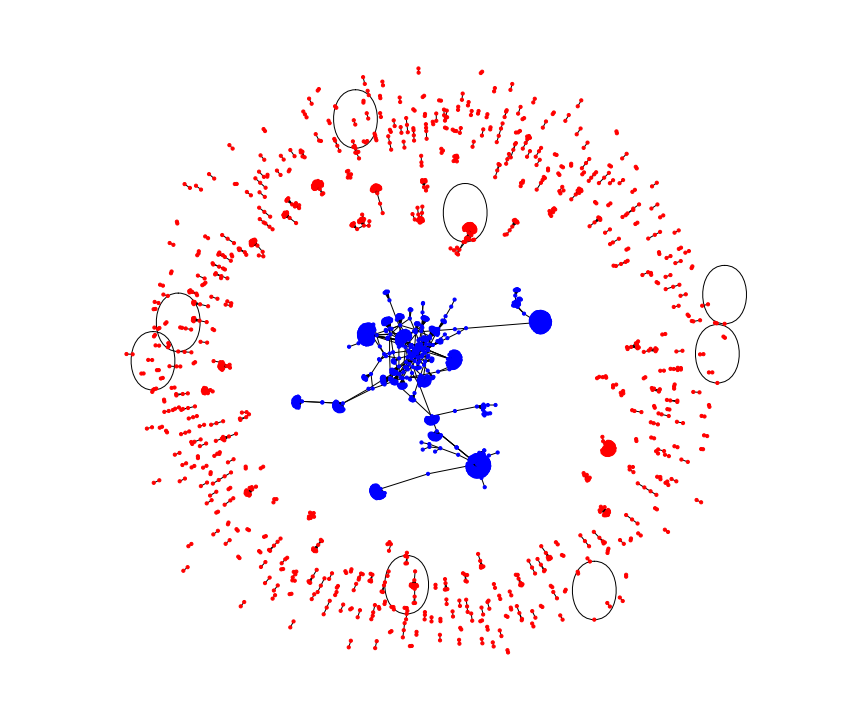

In [150]:
# Visualisasi Komunitas
color_map = []
node_satu = []
node_dua = []
for node in G:
    if node in list_komunitas[0]:
        color_map.append('blue')
        node_satu.append(node)
    else: 
        color_map.append('red')  
        node_dua.append(node) 

fig, ax = plt.subplots(figsize=(15,13))
nx.spring_layout(G,k=0.05)
sc = nx.draw(G, node_color=color_map, cmap='viridis', with_labels=False, ax=ax, node_size=10,width=1)
plt.axis('equal')
plt.show()

### Node Bewarna Biru (node_satu)

Mencari 5 kata yang terbanyak pada node bewarna biru

In [151]:
node_biru = DataFrame(node_satu,columns=['from_user'])

Gabungkan kedua dataframe

In [152]:
biru = pd.merge(node_biru, raw, on="from_user", how="left")
biru.head()

,from_user,id_str,text,created_at,time,geo_coordinates,user_lang,in_reply_to_user_id_str,in_reply_to_screen_name,from_user_id_str,in_reply_to_status_id_str,source,profile_image_url,user_followers_count,user_friends_count,user_location,status_url,entities_str
0,00masan00,1.478650e+18,fujiplus fujiplus httpstcombeaojleu htt...,Wed Jan 05 08:49:25 +0000 2022,05/01/2022 08:49:25,NaN,NaN,NaN,NaN,1.447805e+18,NaN,"<a href=""http://twitter.com/download/iphone"" r...",http://pbs.twimg.com/profile_images/1458068814...,NaN,10.0,NaN,http://twitter.com/00masan00/statuses/14786498...,"{""hashtags"":[{""text"":""やっぱりアニメがすき"",""indices"":[1..."
1,fujitvplus,1.478651e+18,voxykome httpstcoqetzdsq httpstcotnhbaxe,Wed Jan 05 08:55:29 +0000 2022,05/01/2022 08:55:29,NaN,NaN,2.593313e+09,voxy_kome,2.226231e+09,NaN,"<a href=""https://products.comnico.jp/atelu/jp""...",http://pbs.twimg.com/profile_images/1300683826...,141877.0,799.0,東京台場,http://twitter.com/fujitvplus/statuses/1478651...,"{""hashtags"":[],""symbols"":[],""user_mentions"":[{..."
2,fujitvplus,1.478651e+18,hahahah httpstcokdiicll httpstcobnmenne,Wed Jan 05 08:55:26 +0000 2022,05/01/2022 08:55:26,NaN,NaN,1.256181e+18,hahahah25335616,2.226231e+09,NaN,"<a href=""https://products.comnico.jp/atelu/jp""...",http://pbs.twimg.com/profile_images/1300683826...,141877.0,799.0,東京台場,http://twitter.com/fujitvplus/statuses/1478651...,"{""hashtags"":[],""symbols"":[],""user_mentions"":[{..."
3,fujitvplus,1.478651e+18,xyow httpstcobofbpwmra httpstcohaneagcqxs,Wed Jan 05 08:55:23 +0000 2022,05/01/2022 08:55:23,NaN,NaN,1.029208e+18,xy_ow,2.226231e+09,NaN,"<a href=""https://products.comnico.jp/atelu/jp""...",http://pbs.twimg.com/profile_images/1300683826...,141877.0,799.0,東京台場,http://twitter.com/fujitvplus/statuses/1478651...,"{""hashtags"":[],""symbols"":[],""user_mentions"":[{..."
4,fujitvplus,1.478651e+18,rk httpstcozsynehel httpstcowvvznioog,Wed Jan 05 08:55:22 +0000 2022,05/01/2022 08:55:22,NaN,NaN,1.260161e+18,rk96128,2.226231e+09,NaN,"<a href=""https://products.comnico.jp/atelu/jp""...",http://pbs.twimg.com/profile_images/1300683826...,141877.0,799.0,東京台場,http://twitter.com/fujitvplus/statuses/1478651...,"{""hashtags"":[],""symbols"":[],""user_mentions"":[{..."


In [153]:
# 5 Komunitas Tertinggi Node Biru
node_biru_top = 5
text = biru.text.str.lower().str.replace(r'\|', ' ').str.cat(sep=' ')
words = nltk.tokenize.word_tokenize(text)
word_dist = nltk.FreqDist(words)
stopwords = nltk.corpus.stopwords.words('english')
words_except_stop_dist = nltk.FreqDist(w for w in words if w not in stopwords) 
print("5 Komunitas Tertinggi Node Biru")
print("===============================")
hasil_biru = pd.DataFrame(word_dist.most_common(node_biru_top), columns=['Kata', 'Jumlah'])
print(hasil_biru)           

5 Komunitas Tertinggi Node Biru
                Kata  Jumlah
0              toman     418
1           fujiplus     358
2          shikimori     266
3                box     186
4  httpstcombeaojleu     178


### Node Bewarna Merah (node_dua)

Mencari 5 kata yang terbanyak pada node bewarna biru

In [154]:
node_merah = DataFrame(node_dua,columns=['from_user'])

Gabungkan kedua dataframe

In [155]:
merah = pd.merge(node_merah, raw, on="from_user", how="left")
merah.head()

,from_user,id_str,text,created_at,time,geo_coordinates,user_lang,in_reply_to_user_id_str,in_reply_to_screen_name,from_user_id_str,in_reply_to_status_id_str,source,profile_image_url,user_followers_count,user_friends_count,user_location,status_url,entities_str
0,00xxyz_,1.478650e+18,lilaccountz bukannya membenarkan tapi mending...,Wed Jan 05 08:49:09 +0000 2022,05/01/2022 08:49:09,NaN,NaN,NaN,NaN,1.200616e+18,NaN,"<a href=""http://twitter.com/download/android"" ...",http://pbs.twimg.com/profile_images/1478340958...,9.0,18.0,"Tokyo-to, Japan",http://twitter.com/00xxyz_/statuses/1478649758...,"{""hashtags"":[],""symbols"":[],""user_mentions"":[{..."
1,lilaccountz,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,011794skz,1.478650e+18,today bihday senku ishigami dr stone let giv...,Wed Jan 05 08:50:19 +0000 2022,05/01/2022 08:50:19,NaN,NaN,NaN,NaN,1.321754e+18,NaN,"<a href=""http://twitter.com/download/android"" ...",http://pbs.twimg.com/profile_images/1431755046...,14.0,468.0,NaN,http://twitter.com/011794skz/statuses/14786500...,"{""hashtags"":[],""symbols"":[],""user_mentions"":[{..."
3,Anime,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0pointtue,1.478650e+18,naraphoria comparison golden wind stone ocean...,Wed Jan 05 08:50:16 +0000 2022,05/01/2022 08:50:16,NaN,NaN,NaN,NaN,1.239964e+18,NaN,"<a href=""http://twitter.com/#!/download/ipad"" ...",http://pbs.twimg.com/profile_images/1319682780...,20.0,584.0,the mother-lobe,http://twitter.com/0pointtue/statuses/14786500...,"{""hashtags"":[],""symbols"":[],""user_mentions"":[{..."


In [156]:
# 5 Komunitas Tertinggi Node Merah
node_merah_top = 5
text = merah.text.str.lower().str.replace(r'\|', ' ').str.cat(sep=' ')
words = nltk.tokenize.word_tokenize(text)
word_dist = nltk.FreqDist(words)
stopwords = nltk.corpus.stopwords.words('english')
words_except_stop_dist = nltk.FreqDist(w for w in words if w not in stopwords) 
print("5 Komunitas Tertinggi Node Merah")
print("===============================")
hasil_merah = pd.DataFrame(word_dist.most_common(node_merah_top), columns=['Kata', 'Jumlah'])
print(hasil_merah)           

5 Komunitas Tertinggi Node Merah
               Kata  Jumlah
0                de      84
1                pv      61
2          nhkworld      59
3  httpstcoxxqnegkw      59
4  httpstcowgytsvgs      59
